## The below notebook is the first trial run of running summa at the Andrews


## Loading the required modules

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pysumma as ps
import pysumma.plotting as psp
import matplotlib.pyplot as plt
# copies cloned data to a working directory. Common for local setup for intalling
# renoylds data to my machine. 

# Change directory to the correct workspace contaning my forcing, out, and settings folder. Also the file manager
!cd Andrews_data/Andrews_test && ./install_local_setup.sh && cd -
#!cd data/reynolds && ./install_local_setup.sh && cd -
#os.chdir('/Users/ianwhidden/opt/anaconda3/envs')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
/Users/ianwhidden/pysumma/tutorial


<br>

## Instantiating a simulation object

To set up a `Simulation` object, 2 pieces of information must be applied. 

First, the SUMMA executable; this is a compiled executable on my local machine. Could be a docker image. 

The second piece of information is the path to the file manager, which contains all file paths and names needed for a SUMMA simulation run.

To create the `Simulation` object you can then just pass these to the constructor as shown below.

In [2]:
# Define location of .exe and file manager
executable = 'summa.exe'

# The folder 'Andrews_data' is a copy of the 'data' folder
# The 'Andrews_test' test folder is a copy of the reynolds folder that I intend to modify for the Andrews

#file_manager = './Andrews_data/reynolds/file_manager.txt'
file_manager = './Andrews_data/Andrews_test/file_manager.txt'
#file_manager = './Andrews_data/Andrews_test/copy_file_manager.txt'

In [3]:
# Create a model instance
s = ps.Simulation(executable, file_manager)

<br>

## Manipulating the configuration of the simulation object

Most of your interactions with pysumma will be facilitated through this `Simulation` object, so let's take some time to look through what is in it. 
What's contained in the `Simulation` object right after instantiation is generally just the input required for a SUMMA run.
For a more in depth discussion of what these are see the [SUMMA Input](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/) page of the documentation.
There are several attributes of interest that can be examined. 
To see each of them you can simply `print` them. 
Here's a very high level overview of what's available:

* `s.manager` - the file manager
* `s.decisions` - the decisions file
* `s.output_control` - defines what variables to write out
* `s.force_file_list` - a listing of all of the forcing files to use
* `s.local_attributes` - describes GRU/HRU attributes (lat, lon, elevation, etc)
* `s.global_hru_params` - listing of spatially constant local (HRU) parameter values
* `s.global_gru_params` - listing of spatially constant basin (GRU) parameter values
* `s.trial_params` - spatially distributed parameter values (will overwrite `local_param_info` values, can be either HRU or GRU)

Most of these objects have a similar interface defined, with exceptions being `local_attributes` and `parameter_trial`. Those two are standard `xarray` datasets. All others follow the simple API:

```
print(x)                   # Show the data as SUMMA reads it
x.get_option(NAME)         # Get an option
x.set_option(NAME, VALUE)  # Change an option
x.remove_option(NAME)      # Remove an option
```

More intuitively, you can use `key` - `value` type indexing like dictionaries, dataframes, and datasets:

```
print(x['key'])    # Get an option
x['key'] = value   # Change an option
```

In [4]:
# Start experimenting with the sumulation object 's'

# Show what exists currently in file manager AKA master config file
print(s.manager)

# Pring something by key
#print(s.manager['attributeFile'])


# an option is a choice for a model decision. Ask Andrew about this. The below cell shows this better.
# s.get_option(soilCatTbl) 
# s.set_option()
# s.remove_option()

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1999-10-01 01:00'
simEndTime                           '2002-09-30 23:00'
tmZoneInfo                           'localTime'
settingsPath                         '/Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/settings/'
forcingPath                          '/Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/forcing/'
outputPath                           '/Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'forcing_file_list.txt'
initCondition

In [5]:
# view forcing file 
#print(s.force_file_list)
# view LocalAttributes NetCDF
print(s.local_attributes)
print(s.trial_params)

<xarray.Dataset>
Dimensions:         (hru: 1, gru: 1)
Dimensions without coordinates: hru, gru
Data variables: (12/14)
    hruId           (hru) int32 1001
    gruId           (gru) int32 1001
    hru2gruId       (hru) int32 1001
    downHRUindex    (hru) int32 0
    longitude       (hru) float64 243.2
    latitude        (hru) float64 43.2
    ...              ...
    tan_slope       (hru) float64 0.2083
    contourLength   (hru) float64 180.8
    slopeTypeIndex  (hru) int32 1
    soilTypeIndex   (hru) int32 8
    vegTypeIndex    (hru) int32 7
    mHeight         (hru) float64 3.0
Attributes:
    history:  Converted to NetCDF using "localAttributes_ascii_to_nc.py --nc_...
<xarray.Dataset>
Dimensions:             (hru: 1)
Dimensions without coordinates: hru
Data variables: (12/15)
    hruIndex            (hru) float64 1.001e+03
    frozenPrecipMultip  (hru) float64 1.0
    rootingDepth        (hru) float64 1.0
    rootDistExp         (hru) float64 0.5
    theta_sat           (hru) floa

## Time to start setting the model decisions

First, I need to establish what already exists in this file

In [6]:
# The decisions file is contained within the settings folder
s.decisions

<br> 

Great, I can see what's in there. But to be able to change anything I need to know the available options for each decision. The below code shows the `snowIncept` option, which describes the parameterization for snow interception in the canopy. First it will be extracted from the `decisions` object directly, and then query what it can be changed to, then finally change the value to something else.

<br>

In [7]:
# Get just the `snowIncept` option
print(s.decisions['snowIncept'])

# Look at what a decision option can be set it to
print(s.decisions['snowIncept'].available_options)

# Change an option value 
s.decisions['snowIncept'] = 'stickySnow'
print(s.decisions['snowIncept'])

snowIncept    lightSnow            ! choice of parameterization for snow interception
['stickySnow', 'lightSnow']
snowIncept    stickySnow           ! choice of parameterization for snow interception


In [8]:
# Get just the `snowIncept` option
print(s.decisions['LAI_method'])

# Change decision option for LAI method from monTable to specified
s.decisions['LAI_method'] = 'specified'
print(s.decisions['LAI_method'])

LAI_method    monTable             ! choice of method to determine LAI and SAI
LAI_method    specified            ! choice of method to determine LAI and SAI


## Example to change the snowDenNew decision

Changes the model decision that detetermines the density of freshly fallen snow. I changed it from constant density to that outlined in Hedstrom and Pomroy

In [9]:
# Get just the `snowDenNew` option
print(s.decisions['snowDenNew'])

# Look at what a decision option can be set it to
print(s.decisions['snowDenNew'].available_options)

# Change an option value 
s.decisions['snowDenNew'] = 'hedAndPom'
print(s.decisions['snowDenNew'])

snowDenNew    constDens            ! choice of method for new snow density
['hedAndPom', 'anderson', 'pahaut_76', 'constDens']
snowDenNew    hedAndPom            ! choice of method for new snow density


## Now it's time to look at the parameters

Much like the decisions I can manipulate the `global_hru_param` file. This is the local parameters file. The local parameters file is an ASCII file that specifies spatially constant parameter values for SUMMA parameters.
First, let's look at what's contained in it:

In [10]:
# First column is parameter name, second is default value, third is lower limit, fourth is upper limit
print(s.global_hru_params)

upperBoundHead            |      -7.5d-1 |      -1.0d+2 |      -1.0d-2
lowerBoundHead            |       0.0000 |      -1.0d+2 |      -1.0d-2
upperBoundTheta           |       0.2004 |       0.1020 |       0.3680
lowerBoundTheta           |       0.1100 |       0.1020 |       0.3680
upperBoundTemp            |     272.1600 |     270.1600 |     280.1600
lowerBoundTemp            |     274.1600 |     270.1600 |     280.1600
tempCritRain              |     273.1600 |     272.1600 |     274.1600
tempRangeTimestep         |       2.0000 |       0.5000 |       5.0000
frozenPrecipMultip        |       1.0000 |       0.5000 |       1.5000
snowfrz_scale             |      50.0000 |      10.0000 |    1000.0000
fixedThermalCond_snow     |       0.3500 |       0.1000 |       1.0000
albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoMinWinter           |       0.5500 |       0.6000 |       1.0000
albedoMinSpring           |       0.5500 |       0.3000 |       1.0000
albedo

## Lets look at an example of how to change the `gloabl_hru_param` file

In [11]:
# Print it
print('old: ' + str(s.global_hru_params['albedoMax']))

# Change the value
s.global_hru_params['albedoMax'] = 0.9
print('new: ' + str(s.global_hru_params['albedoMax']))

# Print newSnowDenMin
print('Additional example: ' + str(s.global_hru_params['newSnowDenMin']))

old: albedoMax                 |       0.8400 |       0.7000 |       0.9500
new: albedoMax                 |       0.9000 |       0.9000 |       0.9000
Additional example: newSnowDenMin             |     100.0000 |      50.0000 |     100.0000


<br>

### The output control file
Here I can modify what get's written to output. 
The output control file represents the options available through columns of numeric values.
These numbers represent how to write the output. 
From the SUMMA documentation (https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/#output-control-file) they are arranged as:

```
! varName          | outFreq | inst | sum | mean | var | min | max | mode
```

As before, let's look at what's in the `output_control` by simply printing it out:


In [12]:
print(s.output_control)

nSnow                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSWE                            | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowDepth                      | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowfallTemp                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowAge                        | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarExfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarTotalSoilLiq                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarTotalSoilIce                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceRunoff                  | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceTemp                    | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowSublimation                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowDrainage                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarRainfall                       | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowfall                    

<br>

Note that SUMMA is pretty flexible in its output. What is shown above is a pretty typical output file configuration that contains most of the major state variables and fluxes. For a more complete overview of what you can ask SUMMA to output, see: https://github.com/NCAR/summa/blob/master/build/source/dshare/var_lookup.f90

We can modify values in the existing `output_control` in a couple of ways:

In [13]:
# Check the settings for one of the output variables
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

# Change the output statistic from instantaneous to sum (sum to intantaneous?)
s.output_control['scalarInfiltration'] = [1, 1, 0, 0, 0, 0, 0, 0]
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

# We could also be more verbose:
s.output_control['scalarInfiltration'] = {
    'period': 1, 'instant': 1, 'sum': 0, 
    'mean': 0, 'variance': 0, 'min': 0, 'max': 0
}
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant
scalarInfiltration                   | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0
sum
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant


<br>

## Running the summa model through pysumma and manipulating output

The above cells are an overview of some ways to interact with SUMMA configurations through pysumma.
Now, to run a simulation. 
Before doing so I will reset the `Simulation` object, which will discard all of the changes that have been made and load in a clean setup. 

Alternatively I could simply instantiate a new `Simulation` object.
After running the simulation, there is code to make sure it was completed successfully by checking the status.
With a complete run, the output can be viewed simply by using the simulation's `output` attribute.
It is simply an xarray dataset, which can be manipulated in all of ways associated with that type of dataset.

In [14]:
s.reset()
# Or you could just create a new simulation object like before:
#s = ps.Simulation(executable, file_manager)

<br>

Before the model is run, I should ensure that the output directory specified in the fileManger actually exists. If it doesn't, SUMMA will notify me of this and abort the simulation.

In [15]:
# module to handle tasks related to files and folders
import os 

# Make the output directory if it doesn't exist
print('Current specified output directory: ' + s.manager['outputPath'].value) 
if not os.path.exists(s.manager['outputPath'].value):
    os.makedirs(s.manager['outputPath'].value)

Current specified output directory: /Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/output/


<br>

Now we can try a model run.

In [16]:
s.run('local', run_suffix='_default') # run_suffix allows you to specify a string that will be added to the output file name. This is very useful to keep track of different experiments
print(s.status)
print(s.stdout)

Success
file_suffix is '_default'.
file_master is '/Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/.pysumma/_default/file_manager.txt'.
   1 controlVersion: SUMMA_FILE_MANAGER_V3.0.0
   2 simStartTime: 1999-10-01 01:00
   3 simEndTime: 2002-09-30 23:00
   4 tmZoneInfo: localTime
   5 settingsPath: /Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/.pysumma/_default/settings/
   6 forcingPath: /Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/forcing/
   7 outputPath: /Users/ianwhidden/pysumma/tutorial/Andrews_data/Andrews_test/output/
   8 decisionsFile: snow_zDecisions.txt
   9 outputControlFile: snow_zOutputControl.txt
  10 globalHruParamFile: snow_zLocalParamInfo.txt
  11 globalGruParamFile: snow_zBasinParamInfo.txt
  12 attributeFile: snow_zLocalAttributes.nc
  13 trialParamFile: snow_zParamTrial.nc
  14 forcingListFile: forcing_file_list.txt
  15 initConditionFile: snow_zInitCond.nc
  16 outFilePrefix: reynolds
  17 vegTableFile: VEGPARM.TBL
  18 

If `'Success'` is printed out after running the simulation, the model run completed. For further details about the simulation the full output log that SUMMA produces can be viewed by printing out `s.stdout`. In the event that `s.status` does not return `Success` I may wish to inspect this log to diagnose the problem further. `s.stderror` and `s.stdout` can provide details about the error.

<br>

## Data visualization and plotting

Now that some output is produced, the results can be plotted. Because the output is an xarray `DataSet` I can use the convenient plotting capabilities provided by xarray.

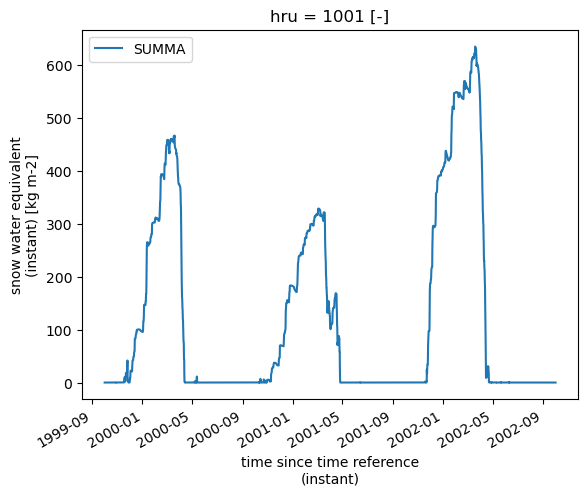

In [17]:
s.output['scalarSWE'].plot(label='SUMMA');
plt.legend();
# note that 'plt' relies on: 'import matplotlib.pyplot as plt' which is magically included in 
# the line `%pylab inline` in the first code block

# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20)

<br>

Additionally, pysumma provides some more specialized plotting capabilities. To access it the `ps.plotting` module is used. First, lets plot the vertical layers over time. For this we will use `ps.plotting.layers`, which requires two pieces of information. First, the variable that you want to plot. It should have both `time` and `midToto` dimensions. The first plot we will make will be the temperature, which uses the variable `mLayerTemp`, and the second will be the volumetric fraction of water content in each layer, which uses `mLayerVolFracWat`. To start out we will give these more convenient names.


In [18]:
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

Now we can plot this using our function. For the temperature plot we will set `plot_soil` to `False` so that we only plot the snowpack. We can see that the top layers of the snowpack respond more quickly to the changing air temperature, and that later in the season the warmer air causes temperature transmission to lower layers and ultimately melts out. 

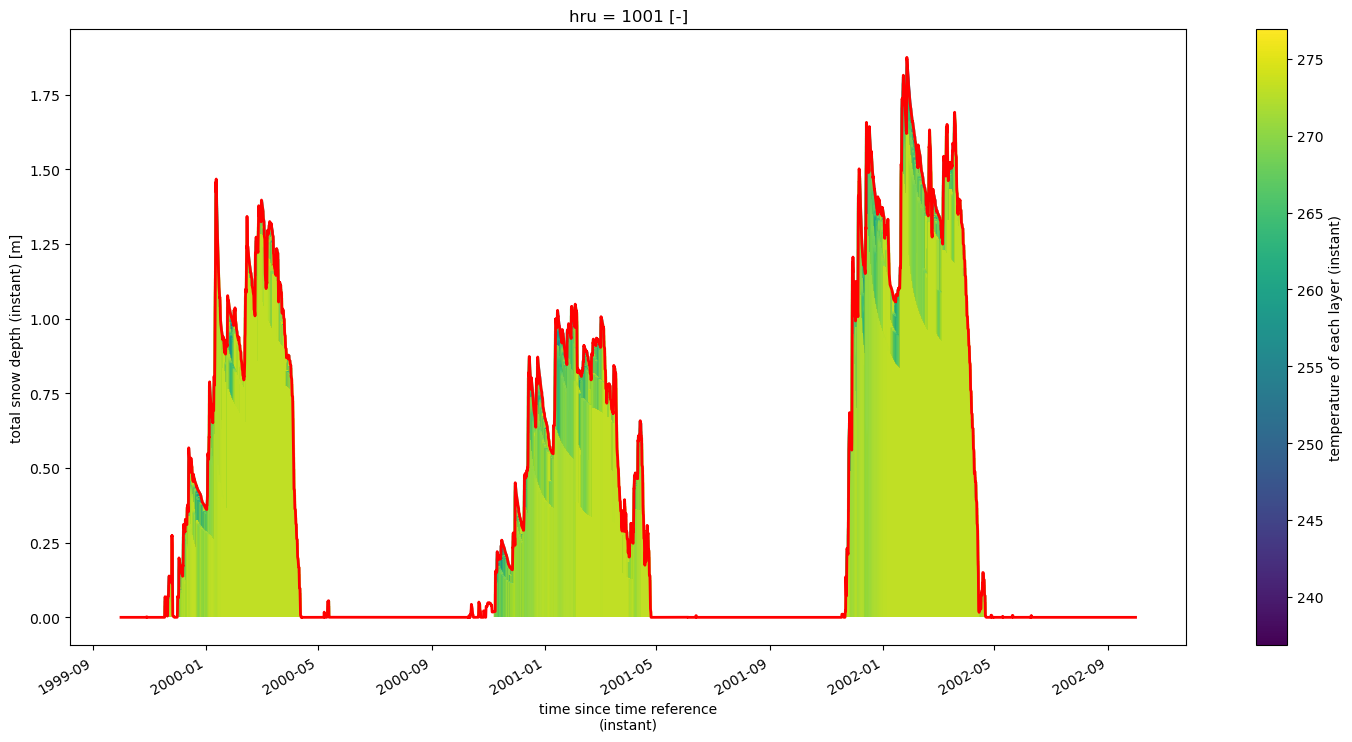

In [19]:
psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);
# plt.rcParams.update({'font.size': 52})

By looking at the volumetric water content we can see even more details. Now we will set `plot_soil` to `True` so that we can see how snowmelt can cause water infiltration into the soil. For example, during the melt season in 2012 we can easily see how the snowmelt infiltrates into the ground.

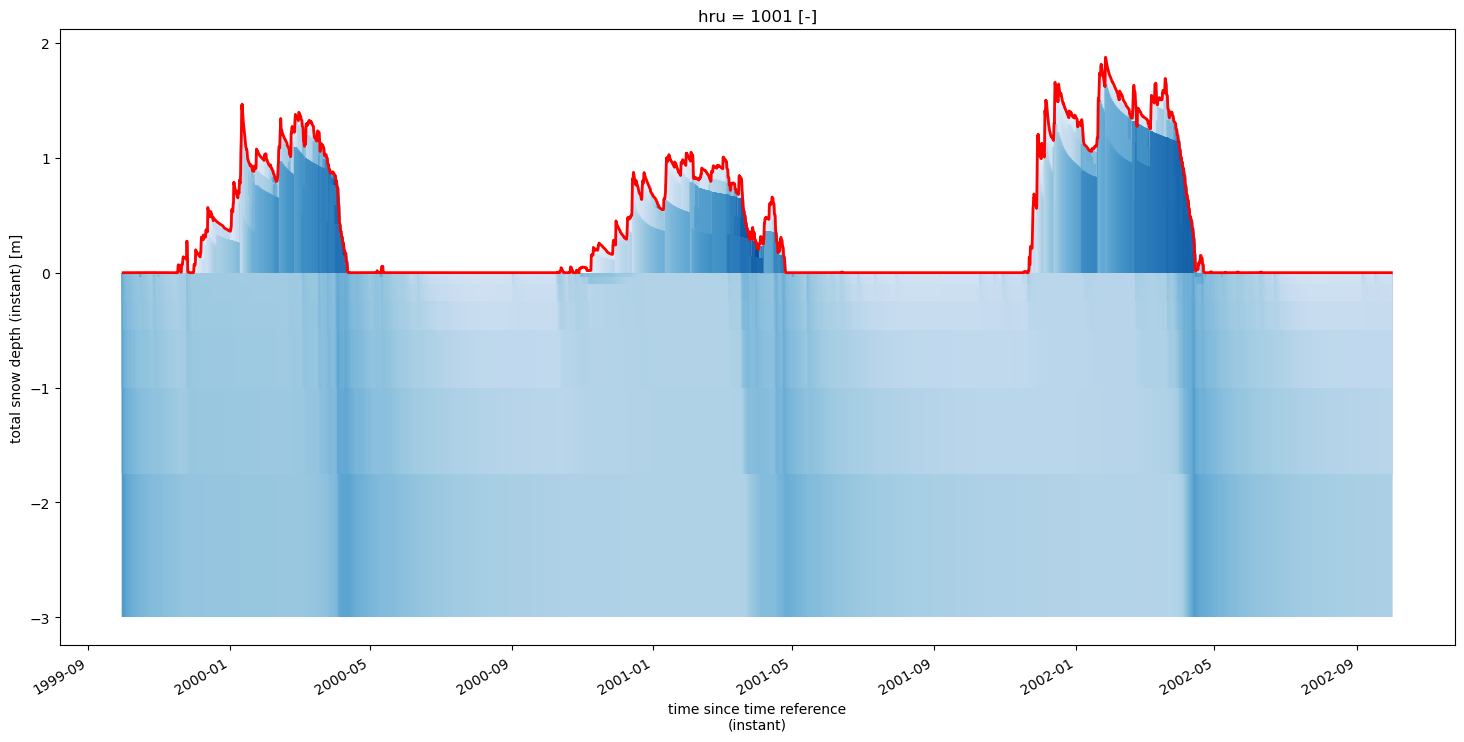

In [20]:
psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);